# Superpoint test 

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import math
import random


DATA_ROOT = os.path.expanduser("../data")
TILE_DIR  = os.path.join(DATA_ROOT, "rubin_tiles_ecdfs_gr_i")


class RubinTileDataset(Dataset):
    def __init__(self, tile_dir):
        self.files = sorted(glob.glob(os.path.join(tile_dir, "*.npz")))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        f = np.load(self.files[idx])
        img = torch.from_numpy(f["img"]).float()   # [B,H,W]
        var = torch.from_numpy(f["var"]).float()
        msk = torch.from_numpy(f["mask"]).long()
        return img, var, msk

ds = RubinTileDataset(TILE_DIR)
dl = DataLoader(ds, batch_size=2, shuffle=True, num_workers=2)

img, var, msk = next(iter(dl))
img.shape, var.shape, msk.shape


(torch.Size([2, 3, 512, 512]),
 torch.Size([2, 3, 512, 512]),
 torch.Size([2, 3, 512, 512]))

In [2]:

def robust_norm(x: torch.Tensor, eps: float = 1e-6, clip: float = 8.0) -> torch.Tensor:
    """
    Robust per-image normalization:
      (x - median) / (1.4826 * MAD)
    Optionally clip to [-clip, clip] to stabilize training.
    x: [..., H, W] or [H, W]
    """
    med = x.median()
    mad = (x - med).abs().median()
    x = (x - med) / (1.4826 * mad + eps)
    if clip is not None:
        x = x.clamp(-clip, clip)
    return x


class SuperPointLite(nn.Module):
    def __init__(self, desc_dim=64):
        super().__init__()

        # stride 2 instead of 4 (only one pooling)
        self.backbone = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 512 -> 256

            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),

            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
        )

        self.det_head  = nn.Conv2d(128, 1, 1)
        nn.init.constant_(self.det_head.bias, -4.0)  # starts near ~0.018
        self.desc_head = nn.Conv2d(128, desc_dim, 1)

    def forward(self, x):
        f = self.backbone(x)
        heatmap = torch.sigmoid(self.det_head(f))          # [N,1,256,256]
        desc = F.normalize(self.desc_head(f), p=2, dim=1)  # [N,D,256,256]
        return heatmap, desc

def sample_affine_params():
    return dict(
        angle=random.uniform(-5, 5),
        translate=(random.uniform(-5, 5), random.uniform(-5, 5)),
        scale=random.uniform(0.98, 1.02),
        shear=random.uniform(-2, 2),
    )

def apply_affine(img, params, interpolation=TF.InterpolationMode.BILINEAR):
    """
    img: [H,W] or [1,H,W] (torch tensor)
    returns: same shape as input
    NOTE: TF.affine expects [C,H,W] tensor (no batch).
    """
    if img.ndim == 2:
        img_in = img.unsqueeze(0)          # [1,H,W]
        out = TF.affine(img_in, interpolation=interpolation, **params)  # [1,H,W]
        return out.squeeze(0)              # [H,W]
    elif img.ndim == 3:
        return TF.affine(img, interpolation=interpolation, **params)    # [C,H,W]
    else:
        raise ValueError(f"apply_affine expects [H,W] or [C,H,W], got shape {tuple(img.shape)}")



def detector_losses(h0, h0_warped, h1, p_tgt=0.01):
    """
    h0_warped should be h0 warped with the same affine used on the image.
    """
    loss_repeat = F.mse_loss(h0_warped, h1)

    p0 = h0.mean()
    p1 = h1.mean()
    loss_density = (p0 - p_tgt).pow(2) + (p1 - p_tgt).pow(2)
    loss_sparse = (p0 + p1) * 0.5
    loss_peak   = -((h0**2).mean() + (h1**2).mean()) * 0.5
    loss_floor = F.relu(p_tgt * 0.5 - p0) + F.relu(p_tgt * 0.5 - p1)

    return loss_repeat, loss_density, loss_sparse, loss_peak,loss_floor

def local_contrast_loss(h, k=7):
    """
    Encourage local maxima by penalizing pixels that are close to their local average.
    h: [N,1,H,W]
    """
    avg = F.avg_pool2d(h, k, stride=1, padding=k//2)
    return -((h - avg)**2).mean()


def sample_from_heatmap(h, num=256, thr_rel=0.2):
    """
    h: [1,1,hh,ww]
    returns xs, ys on heatmap grid
    """
    hm = h[0,0]
    thr = (thr_rel * hm.max()).clamp(min=0.0)
    ys, xs = torch.where(hm > thr)
    if xs.numel() < num:
        return None
    idx = torch.randperm(xs.numel(), device=xs.device)[:num]
    return xs[idx], ys[idx]

def desc_match_loss(d0, d1, xs, ys):
    """
    d0, d1: [1,D,hh,ww]
    """
    v0 = d0[0, :, ys, xs].T
    v1 = d1[0, :, ys, xs].T
    return F.smooth_l1_loss(v0, v1)





In [3]:
# --- UPDATED TRAINING CELL (drop-in) ---

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SuperPointLite().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)

# loss weights (reasonable starts)
w_rep   = 1.0
w_den   = 50.0     # IMPORTANT: density must matter
w_sparse= 0.2
w_peak  = 0.1
w_desc  = 1.0
w_floor = 1.0
p_tgt   = 0.02     


for step, (img, var, msk) in enumerate(dl):
    # pick a random band
    b = torch.randint(0, img.shape[1], (1,)).item()

    # x0: [N,1,512,512], robust-normalized per tile
    x0 = img[:, b].to(device)                             # [N,512,512]
    x0 = torch.stack([robust_norm(xi) for xi in x0], 0)    # [N,512,512]
    x0 = x0.unsqueeze(1)                                   # [N,1,512,512]

    # build warped pair with known params (per sample)
    params_list = [sample_affine_params() for _ in range(x0.shape[0])]
    
    # warp image (bilinear)
    x1 = torch.stack([apply_affine(x0[i,0], params_list[i]) for i in range(x0.shape[0])], 0).unsqueeze(1)
    
    # forward
    h0, d0 = model(x0)
    h1, d1 = model(x1)
    
    # warp heatmap (bilinear is OK)
    h0w = torch.stack([apply_affine(h0[i,0], params_list[i]) for i in range(h0.shape[0])], 0).unsqueeze(1)


    # detector losses
    loss_rep, loss_den, loss_sparse, loss_peak, loss_floor = detector_losses(h0, h0w, h1, p_tgt=p_tgt)


    # descriptor loss: sample points from confident regions in h0
    loss_desc = 0.0
    n_used = 0
    for i in range(x0.shape[0]):
        kps = sample_from_heatmap(h0[i:i+1], num=256, thr_rel=0.2)
        if kps is None:
            continue
        xs, ys = kps
        loss_desc = loss_desc + desc_match_loss(d0[i:i+1], d1[i:i+1], xs, ys)
        n_used += 1
    if n_used > 0:
        loss_desc = loss_desc / n_used
    else:
        loss_desc = torch.tensor(0.0, device=device)

    # total loss
    loss = (
        w_rep    * loss_rep +
        w_den    * loss_den +
        w_sparse * loss_sparse +
        w_peak   * loss_peak +
        w_desc   * loss_desc+
        w_floor * loss_floor     )

    opt.zero_grad(set_to_none=True)
    loss.backward()
    opt.step()
    if step % 5 == 0:
        print(
            f"step={step} "
            f"loss={loss.item():.4g} "
            f"mean_h={h0.mean().item():.4g} "
            f"max_h={h0.max().item():.4g} "
            f"den={loss_den.item():.4g}")



step=0 loss=0.004009 mean_h=0.01842 max_h=0.02019 den=5.038e-06
step=5 loss=0.003945 mean_h=0.01882 max_h=0.02083 den=3.014e-06
step=10 loss=0.00393 mean_h=0.01904 max_h=0.02056 den=2.148e-06
step=15 loss=0.003903 mean_h=0.01904 max_h=0.01998 den=2.039e-06
step=20 loss=0.003894 mean_h=0.019 max_h=0.01965 den=2.136e-06
step=25 loss=0.003882 mean_h=0.01903 max_h=0.01951 den=2.043e-06
step=30 loss=0.003885 mean_h=0.01903 max_h=0.01941 den=2.005e-06
step=35 loss=0.00388 mean_h=0.01904 max_h=0.01929 den=1.963e-06
step=40 loss=0.00388 mean_h=0.01902 max_h=0.01926 den=2.029e-06
step=45 loss=0.00388 mean_h=0.01903 max_h=0.0192 den=1.971e-06
step=50 loss=0.003875 mean_h=0.01904 max_h=0.01922 den=1.931e-06
step=55 loss=0.003877 mean_h=0.01902 max_h=0.01921 den=1.974e-06
step=60 loss=0.003876 mean_h=0.01904 max_h=0.01923 den=1.914e-06
step=65 loss=0.003878 mean_h=0.01903 max_h=0.01924 den=1.957e-06
step=70 loss=0.003871 mean_h=0.01902 max_h=0.01919 den=1.979e-06


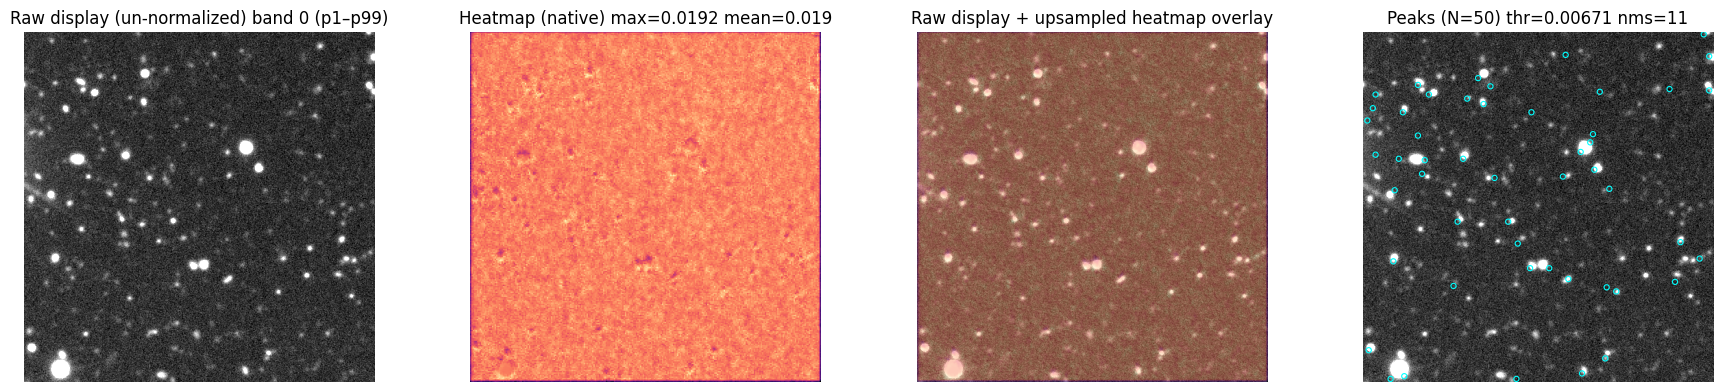

heatmap shape: (256, 256) -> raw shape: (512, 512)
thr_rel=0.35 => thr=0.006709; peaks=50


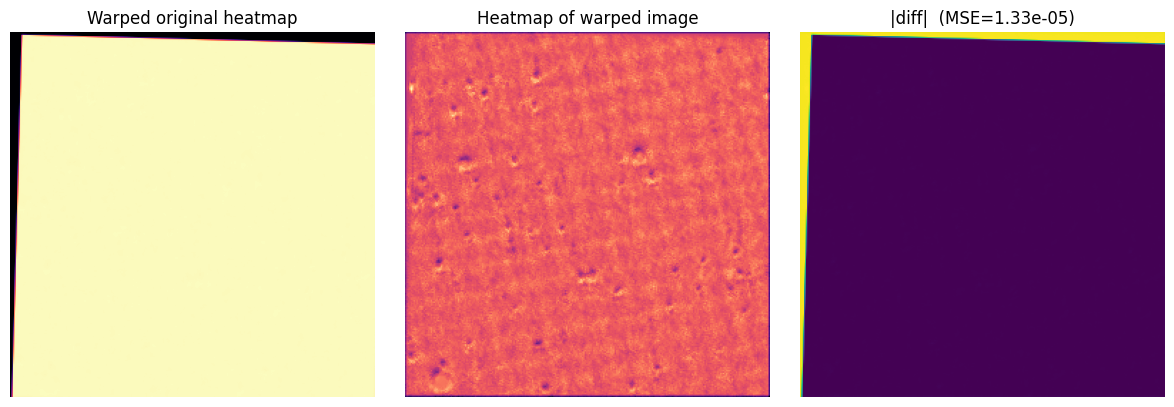

Repeatability MSE (lower is better): 1.326e-05


In [7]:
# -----------------------------
# knobs
# -----------------------------
band   = 0
p_lo, p_hi = 1, 99
nms_ks = 11
thr_rel = 0.35
max_peaks = 50

# repeatability check knobs
do_repeatability_check = True
rep_nms_ks = 11

# -----------------------------
# get one tile
# -----------------------------
img, var, msk = next(iter(dl))
raw0 = img[0, band]                       # [512,512] (UN-normalized)

device = next(model.parameters()).device
model.eval()

# IMPORTANT: normalize the same way as training
raw = robust_norm(raw0).to(device)        # [512,512] (normalized)

# -----------------------------
# run model
# -----------------------------
with torch.no_grad():
    x = raw.unsqueeze(0).unsqueeze(0)     # [1,1,512,512]
    heatmap, desc = model(x)              # heatmap: [1,1,h,w]
    h = heatmap[0,0]                      # [h,w]

# -----------------------------
# NMS + threshold (relative to max)
# -----------------------------
pad = nms_ks // 2
mx = F.max_pool2d(h[None,None], nms_ks, stride=1, padding=pad)[0,0]
thr = (thr_rel * h.max()).clamp(min=0.0)
keep = (h == mx) & (h > thr)

ys_hm, xs_hm = torch.where(keep)
scores = h[ys_hm, xs_hm]

# cap number of peaks
if scores.numel() > max_peaks:
    idx = torch.argsort(scores, descending=True)[:max_peaks]
    xs_hm, ys_hm, scores = xs_hm[idx], ys_hm[idx], scores[idx]

# -----------------------------
# upsample heatmap to raw resolution
# -----------------------------
with torch.no_grad():
    h_up = F.interpolate(heatmap, size=raw.shape, mode="bilinear", align_corners=False)[0,0]  # [512,512]

# map peak coords from heatmap grid -> raw grid
H, W = raw.shape
hh, ww = h.shape
xs = xs_hm.float() * (W / ww)
ys = ys_hm.float() * (H / hh)

# -----------------------------
# display scaling for *UN-normalized* raw (so you see astronomy nicely)
# -----------------------------
raw0_np = raw0.cpu().numpy()
lo, hi = np.percentile(raw0_np, (p_lo, p_hi))

h_np   = h.detach().cpu().numpy()
hup_np = h_up.detach().cpu().numpy()

# -----------------------------
# plots (raw display uses raw0, model input uses raw)
# -----------------------------
fig, axs = plt.subplots(1, 4, figsize=(18, 4))

axs[0].imshow(raw0_np, origin="lower", cmap="gray", vmin=lo, vmax=hi)
axs[0].set_title(f"Raw display (un-normalized) band {band} (p{p_lo}–p{p_hi})")
axs[0].axis("off")

axs[1].imshow(h_np, origin="lower", cmap="magma")
axs[1].set_title(f"Heatmap (native) max={h_np.max():.3g} mean={h_np.mean():.3g}")
axs[1].axis("off")

axs[2].imshow(raw0_np, origin="lower", cmap="gray", vmin=lo, vmax=hi)
axs[2].imshow(hup_np, origin="lower", cmap="magma", alpha=0.45)
axs[2].set_title("Raw display + upsampled heatmap overlay")
axs[2].axis("off")

axs[3].imshow(raw0_np, origin="lower", cmap="gray", vmin=lo, vmax=hi)
axs[3].scatter(xs.cpu(), ys.cpu(), s=14, facecolors="none", edgecolors="cyan", linewidths=0.8)
axs[3].set_title(f"Peaks (N={len(xs)}) thr={thr.item():.3g} nms={nms_ks}")
axs[3].axis("off")

plt.tight_layout()
plt.show()

print(f"heatmap shape: {tuple(h.shape)} -> raw shape: {tuple(raw.shape)}")
print(f"thr_rel={thr_rel} => thr={thr.item():.4g}; peaks={len(xs)}")

# -----------------------------
# repeatability check (optional but VERY informative)
# -----------------------------
if do_repeatability_check:
    params = sample_affine_params()

    with torch.no_grad():
        # warp normalized image (same distribution as training)
        xw = apply_affine(raw, params).unsqueeze(0).unsqueeze(0)  # [1,1,512,512]
        hw, _ = model(xw)                                         # heatmap of warped image

        # warp original heatmap into warped frame (GPU-safe if apply_affine supports device)
        # if apply_affine only works on CPU in your env, do .cpu() then .to(device)
        h0w = apply_affine(heatmap[0,0], params).unsqueeze(0).unsqueeze(0)

        # compare in heatmap grid (native)
        rep_mse = F.mse_loss(h0w, hw).item()

        # visualize repeatability
        h0w_np = h0w[0,0].detach().cpu().numpy()
        hw_np  = hw[0,0].detach().cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(h0w_np, origin="lower", cmap="magma")
    axs[0].set_title("Warped original heatmap")
    axs[0].axis("off")

    axs[1].imshow(hw_np, origin="lower", cmap="magma")
    axs[1].set_title("Heatmap of warped image")
    axs[1].axis("off")

    axs[2].imshow(np.abs(h0w_np - hw_np), origin="lower", cmap="viridis")
    axs[2].set_title(f"|diff|  (MSE={rep_mse:.3g})")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()

    print(f"Repeatability MSE (lower is better): {rep_mse:.4g}")
